# Visualise sample variation
Using the results from the hap.py workflow, visualise the differences between the input samples for precision and recall.


## Load libraries and packages¶

* Fiss
* Pandas & Numpy
* Matplotlib



In [7]:
import os
import firecloud.api as fc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
from io import StringIO

## Set up your workspace and bucket connection

In [8]:
#Set up to connect your notebook to your actual workspace
project = os.environ['WORKSPACE_NAMESPACE']
workspace = os.environ['WORKSPACE_NAME']
bucket = os.environ['WORKSPACE_BUCKET']


## Using the submission id, link the notebook to your output

A submission id can be found in the job history of the workspace.

In [9]:
# id of submission
submission= '8be4b1e9-8baf-480a-a989-edfe13fa658b'

#Given a submission id, get all input, output and metadata.
temp = fc.get_submission(project,workspace,submission).json()

#Information on all the workflows run on that single submission
workflows = temp['workflows']

#For each workflow, extract the sample_id and workflow id and store it in a dictionary
wf = {}
for i in range(len(workflows)):
    wf[workflows[i]['workflowEntity']['entityName']]= [workflows[i]['workflowId']]


### For each sample/workflow, exrtract the summary file output url containing specificity and sensitivity metrics.


In [10]:
for key in wf.keys():
    workflow_id = wf[key][0]
    
    output = fc.get_workflow_outputs(project,workspace,submission,workflow_id).json()
    summary_file = output['tasks']['HappyWorkflow.RunHappy']['outputs']['HappyWorkflow.RunHappy.happy_outputs'][8]
    
    wf[key].append(summary_file)
        
    

In [11]:
sample_ids = list(wf.keys())

def summary2df(wf,sample):
    """
    Opens the summary file and returns content as a pandas dataframe.
    """
    url = wf[sample][1]
    content=!gsutil cat {url}
    data=pd.read_csv(StringIO("\n".join(content)),sep=",")
    
    return data

# Split data into the appropriate clusters
frames = []
C1_frames = []
C2_frames = []
C3_frames = []
C4_frames = []
C5_frames = []
C6_frames = []
C1_samples =[]
C2_samples =[]
C3_samples =[]
C4_samples =[]
C5_samples =[]
C6_samples =[]

for id in sample_ids:
    frames.append(summary2df(wf,id))
    if id.startswith('C1'):
        C1_samples.append(id)
        C1_frames.append(summary2df(wf,id))
    elif id.startswith('C2'):
        C2_frames.append(summary2df(wf,id))
        C2_samples.append(id)
    elif id.startswith('C3'):
        C3_frames.append(summary2df(wf,id))
        C3_samples.append(id)
    elif id.startswith('C4'):
        C4_frames.append(summary2df(wf,id))
        C4_samples.append(id)
    elif id.startswith('C5'):
        C5_frames.append(summary2df(wf,id))
        C5_samples.append(id)
    elif id.startswith('C6'):
        C6_frames.append(summary2df(wf,id))
        C6_samples.append(id)
    

big_df = pd.concat(frames,keys=sample_ids)
C1_df = pd.concat(C1_frames,keys=C1_samples)
C2_df = pd.concat(C2_frames,keys=C2_samples)
C3_df = pd.concat(C3_frames,keys=C3_samples)
C4_df = pd.concat(C4_frames,keys=C4_samples)
C5_df = pd.concat(C5_frames,keys=C5_samples)
C6_df = pd.concat(C6_frames,keys=C6_samples)



## Plot all individual samples 

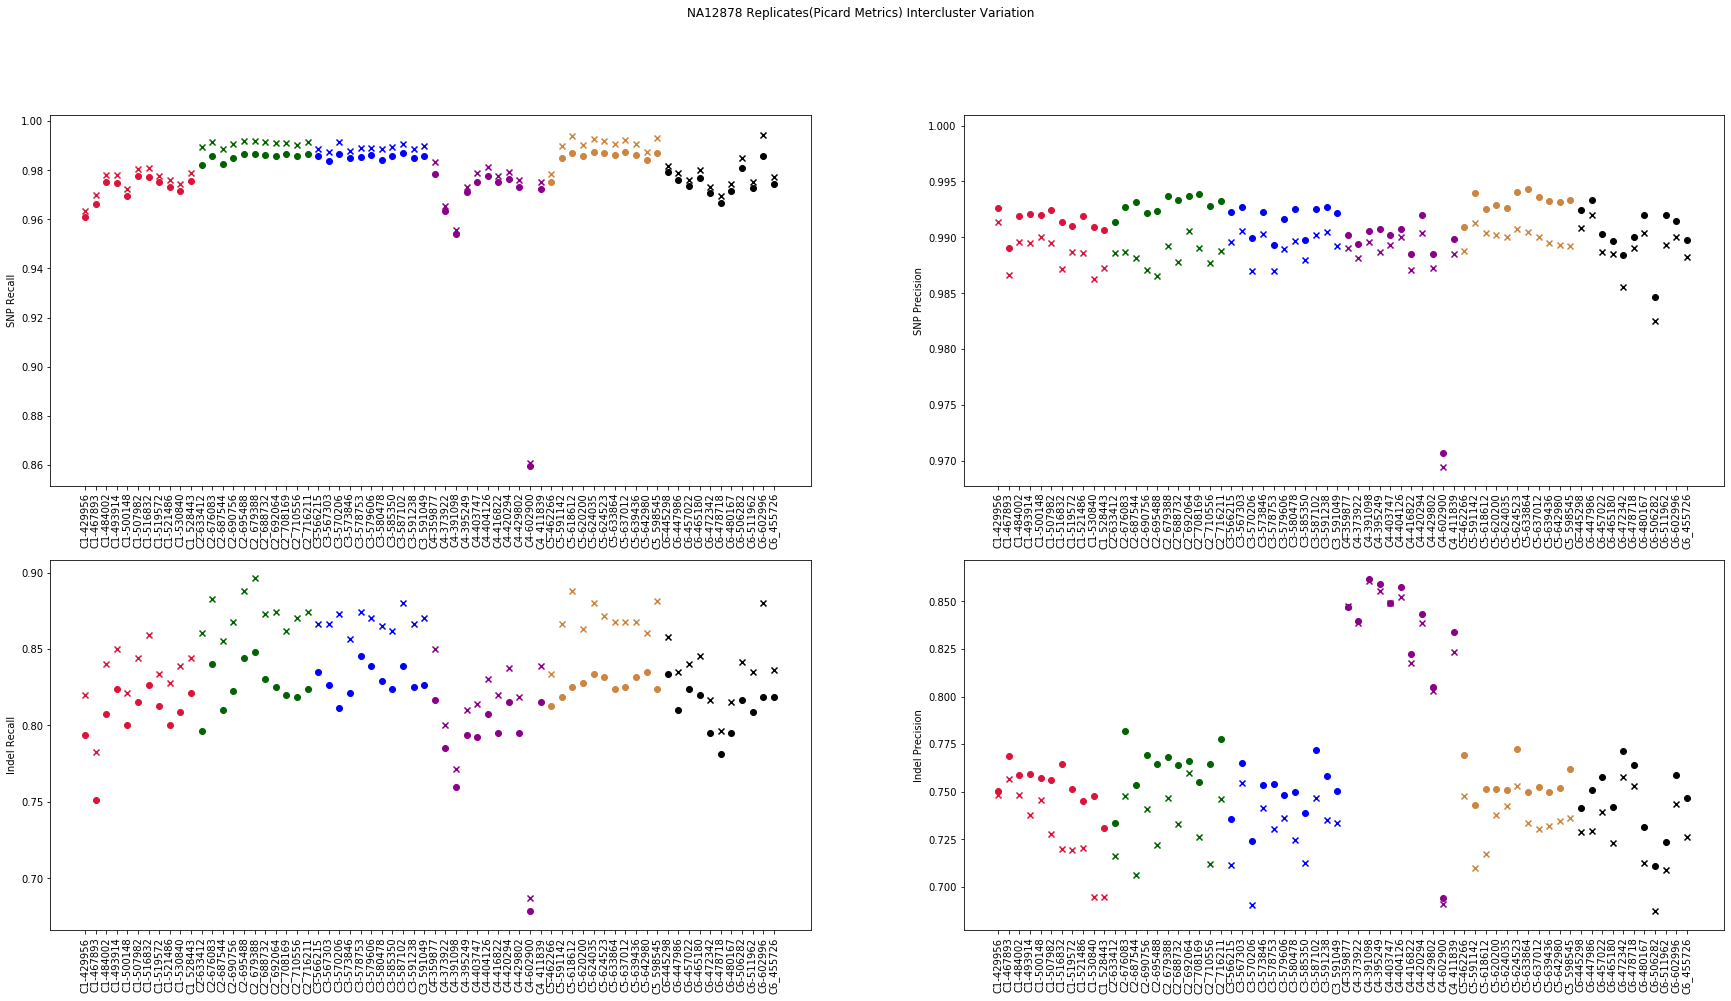

In [16]:
fig = plt.figure(figsize=(30,15))
fig.suptitle('NA12878 Replicates(Picard Metrics) Intercluster Variation') 

ax1 = fig.add_subplot(221)
#ax2 = fig.add_subplot(222, sharex=ax1, sharey=ax1)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224, sharex=ax3, sharey=ax3)
ax4 = fig.add_subplot(224)


def plot_split(id, color,df):
    ax1.scatter(id, df.loc[id].loc[2]['METRIC.Recall'],label='unfiltered',color = color,marker='x')
    ax1.scatter(id, df.loc[id].loc[3]['METRIC.Recall'],label='PASS',color = color,)
    ax2.scatter(id, df.loc[id].loc[2]['METRIC.Precision'],label='unfiltered',color = color,marker='x')
    ax2.scatter(id, df.loc[id].loc[3]['METRIC.Precision'],label='PASS',color = color)    
    ax3.scatter(id, df.loc[id].loc[0]['METRIC.Recall'],label='unfiltered',color = color,marker='x')
    ax3.scatter(id, df.loc[id].loc[1]['METRIC.Recall'],label='PASS',color = color)
    ax4.scatter(id, df.loc[id].loc[0]['METRIC.Precision'],label='unfiltered',color = color,marker='x')
    ax4.scatter(id, df.loc[id].loc[1]['METRIC.Precision'],label='PASS',color = color)


for id in sample_ids:
    if id.startswith('C1'):
        plot_split(id,'crimson',big_df)
    elif id.startswith('C2'):
        plot_split(id,'darkgreen',big_df)
    elif id.startswith('C3'):
        plot_split(id,'blue',big_df)
    elif id.startswith('C4'):
        plot_split(id,'darkmagenta',big_df)
    elif id.startswith('C5'):
        plot_split(id,'peru',big_df)
    elif id.startswith('C6'):
        plot_split(id,'black',big_df)
      
ax1.set_ylabel('SNP Recall')
ax2.set_ylabel('SNP Precision')
ax3.set_ylabel('Indel Recall')
ax4.set_ylabel('Indel Precision')    


for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)


## Calculate mean precision & recall and standard error

In [12]:
clusters = [C1_df,C2_df,C3_df,C4_df,C5_df,C6_df]
samples = [C1_samples,C2_samples,C3_samples,C4_samples,C5_samples,C6_samples]

def get_stats(clusters,samples,x,metric):
    
    means=[]
    err = []
    
    for sample,cluster in zip(samples,clusters):
        snp_recall = []
        for id in sample:
            snp_recall.append(cluster.loc[id].loc[x][metric])
            cluster_mean =  np.mean(snp_recall)
            cluster_std = np.std(snp_recall)
            cluster_sem = cluster_std/ np.sqrt(len(samples))

        means.append(cluster_mean)
        err.append(cluster_sem)

    return means,err

#cluster_means,cluster_sem = get_stats(clusters,samples)
snp_mean_recall,snp_sem_recall = get_stats(clusters,samples,3,'METRIC.Recall')
snp_mean_precision,snp_sem_precision = get_stats(clusters,samples,3,'METRIC.Precision')
indel_mean_recall,indel_sem_recall = get_stats(clusters,samples,1,'METRIC.Recall')
indel_mean_precision,indel_sem_precision = get_stats(clusters,samples,1,'METRIC.Precision')


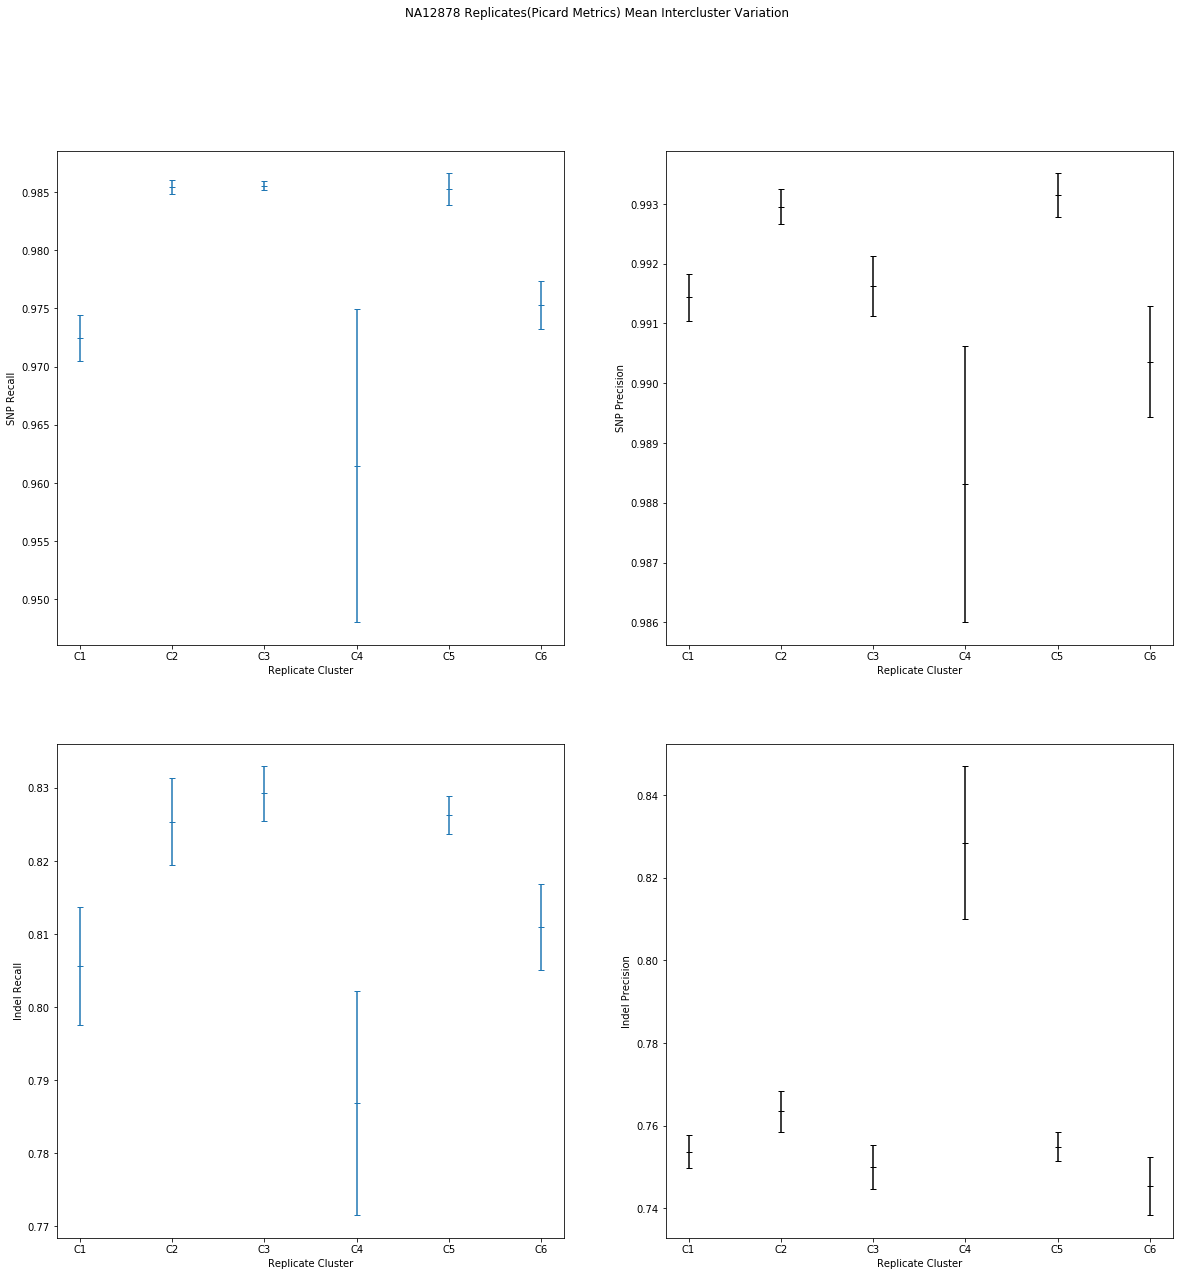

In [17]:
%matplotlib inline

clusters = ['C1','C2','C3','C4','C5','C6']    

fig = plt.figure(figsize=(20,20))
fig.suptitle('NA12878 Replicates(Picard Metrics) Mean Intercluster Variation') 

ax1 = fig.add_subplot(221)
#ax2 = fig.add_subplot(222, sharex=ax1, sharey=ax1)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224, sharex=ax3, sharey=ax3)
ax4 = fig.add_subplot(224)

ax1.errorbar(clusters, snp_mean_recall, yerr=snp_sem_recall,fmt='_',linestyle='None', capsize=3)
ax2.errorbar(clusters, snp_mean_precision, yerr=snp_sem_precision,fmt='_',linestyle='None', capsize=3,color='black')
ax3.errorbar(clusters, indel_mean_recall, yerr=indel_sem_recall,fmt='_',linestyle='None', capsize=3)
ax4.errorbar(clusters, indel_mean_precision, yerr=indel_sem_precision,fmt='_',linestyle='None', capsize=3,color = 'black')
#plt.show()

ax1.set_ylabel('SNP Recall')
ax2.set_ylabel('SNP Precision')
ax3.set_ylabel('Indel Recall')
ax4.set_ylabel('Indel Precision') 

for ax in fig.axes:
    ax.set_xlabel('Replicate Cluster')

## Detailed metrics for each replicate


In [20]:
display(big_df)

#or
#display (C1_df)

Type Filter  TRUTH.TOTAL  TRUTH.TP  TRUTH.FN  QUERY.TOTAL  \
C1-429956 0  INDEL    ALL          732       600       132        31548   
          1  INDEL   PASS          732       581       151        31147   
          2    SNP    ALL        21301     20523       778       192237   
          3    SNP   PASS        21301     20472       829       189581   
C1-467893 0  INDEL    ALL          732       573       159        33754   
          1  INDEL   PASS          732       550       182        33386   
          2    SNP    ALL        21301     20663       638       278412   
          3    SNP   PASS        21301     20586       715       275472   
C1-484002 0  INDEL    ALL          732       615       117        50487   
          1  INDEL   PASS          732       591       141        50056   
          2    SNP    ALL        21301     20834       467       265514   
          3    SNP   PASS        21301     20771       530       262540   
C1-493914 0  INDEL    ALL          732       622       110        50697   
          1  INDEL   PASS          732       603       129        50266   
          2    SNP    ALL        21301     20833       468       264969   
          3    SNP   PASS        21301     20762       539       261712   
C1-500148 0  INDEL    ALL          732       601       131        41429   
          1  INDEL   PASS          732       586       146        41058   
          2    SNP    ALL        21301     20709       592       231740   
          3    SNP   PASS        21301     20653       648       229058   
C1-507982 0  INDEL    ALL          732       618       114        48570   
          1  INDEL   PASS          732       597       135        48103   
          2    SNP    ALL        21301     20884       417       256891   
          3    SNP   PASS        21301     20823       478       254161   
C1-516832 0  INDEL    ALL          732       629       103        60856   
          1  INDEL   PASS          732       605       127        60317   
          2    SNP    ALL        21301     20891       410       297785   
          3    SNP   PASS        21301     20814       487       294418   
C1-519572 0  INDEL    ALL          732       610       122        45335   
          1  INDEL   PASS          732       595       137        44875   
...            ...    ...          ...       ...       ...          ...   
C6-465180 2    SNP    ALL        21301     20874       427       244972   
          3    SNP   PASS        21301     20805       496       242551   
C6-472342 0  INDEL    ALL          732       598       134        26368   
          1  INDEL   PASS          732       582       150        26030   
          2    SNP    ALL        21301     20733       568       211217   
          3    SNP   PASS        21301     20674       627       208472   
C6-478718 0  INDEL    ALL          732       583       149        30816   
          1  INDEL   PASS          732       572       160        30512   
          2    SNP    ALL        21301     20655       646       229709   
          3    SNP   PASS        21301     20590       711       227040   
C6-480167 0  INDEL    ALL          732       597       135        41043   
          1  INDEL   PASS          732       582       150        40655   
          2    SNP    ALL        21301     20759       542       229568   
          3    SNP   PASS        21301     20698       603       226902   
C6-506282 0  INDEL    ALL          732       616       116        43454   
          1  INDEL   PASS          732       598       134        43016   
          2    SNP    ALL        21301     20982       319       297975   
          3    SNP   PASS        21301     20893       408       294892   
C6-511962 0  INDEL    ALL          732       611       121        44102   
          1  INDEL   PASS          732       592       140        43660   
          2    SNP    ALL        21301     20772       529       233546   
          3    SNP   PASS        21301 

In [21]:
display(C1_df)

Type Filter  TRUTH.TOTAL  TRUTH.TP  TRUTH.FN  QUERY.TOTAL  \
C1-429956 0  INDEL    ALL          732       600       132        31548   
          1  INDEL   PASS          732       581       151        31147   
          2    SNP    ALL        21301     20523       778       192237   
          3    SNP   PASS        21301     20472       829       189581   
C1-467893 0  INDEL    ALL          732       573       159        33754   
          1  INDEL   PASS          732       550       182        33386   
          2    SNP    ALL        21301     20663       638       278412   
          3    SNP   PASS        21301     20586       715       275472   
C1-484002 0  INDEL    ALL          732       615       117        50487   
          1  INDEL   PASS          732       591       141        50056   
          2    SNP    ALL        21301     20834       467       265514   
          3    SNP   PASS        21301     20771       530       262540   
C1-493914 0  INDEL    ALL          732       622       110        50697   
          1  INDEL   PASS          732       603       129        50266   
          2    SNP    ALL        21301     20833       468       264969   
          3    SNP   PASS        21301     20762       539       261712   
C1-500148 0  INDEL    ALL          732       601       131        41429   
          1  INDEL   PASS          732       586       146        41058   
          2    SNP    ALL        21301     20709       592       231740   
          3    SNP   PASS        21301     20653       648       229058   
C1-507982 0  INDEL    ALL          732       618       114        48570   
          1  INDEL   PASS          732       597       135        48103   
          2    SNP    ALL        21301     20884       417       256891   
          3    SNP   PASS        21301     20823       478       254161   
C1-516832 0  INDEL    ALL          732       629       103        60856   
          1  INDEL   PASS          732       605       127        60317   
          2    SNP    ALL        21301     20891       410       297785   
          3    SNP   PASS        21301     20814       487       294418   
C1-519572 0  INDEL    ALL          732       610       122        45335   
          1  INDEL   PASS          732       595       137        44875   
          2    SNP    ALL        21301     20825       476       243389   
          3    SNP   PASS        21301     20770       531       240158   
C1-521486 0  INDEL    ALL          732       606       126        56139   
          1  INDEL   PASS          732       586       146        55631   
          2    SNP    ALL        21301     20787       514       279910   
          3    SNP   PASS        21301     20730       571       276511   
C1-530840 0  INDEL    ALL          732       614       118        56767   
          1  INDEL   PASS          732       592       140        56138   
          2    SNP    ALL        21301     20755       546       283385   
          3    SNP   PASS        21301     20695       606       279718   
C1_528443 0  INDEL    ALL          732       618       114        57463   
          1  INDEL   PASS          732       601       131        56912   
          2    SNP    ALL        21301     20853       448       286908   
          3    SNP   PASS        21301     20785       516       283469   

             QUERY.FP  QUERY.UNK  FP.gt  METRIC.Recall  METRIC.Precision  \
C1-429956 0       204      30738     15       0.819672          0.748148   
          1       195      30365     15       0.793716          0.750639   
          2       179     171534     59       0.963476          0.991354   
          3       152     168956     59       0.961082          0.992630   
C1-467893 0       186      32990     18       0.782787          0.756545   
          1       167      32664     18       0.751366          0.768698   
          2       280     257470     41       0.970048          0.986630   
          3       228     2546